In [224]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import os
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

In [208]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [253]:
# Read data
data_dir = './data'
sets = ['test', 'train', 'valid']

# Combine the composed transforms with the additional transforms
composed_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=composed_transform)
    for x in sets
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=6, shuffle=True, num_workers=0) for x in sets}

torch.Size([1, 128, 128])


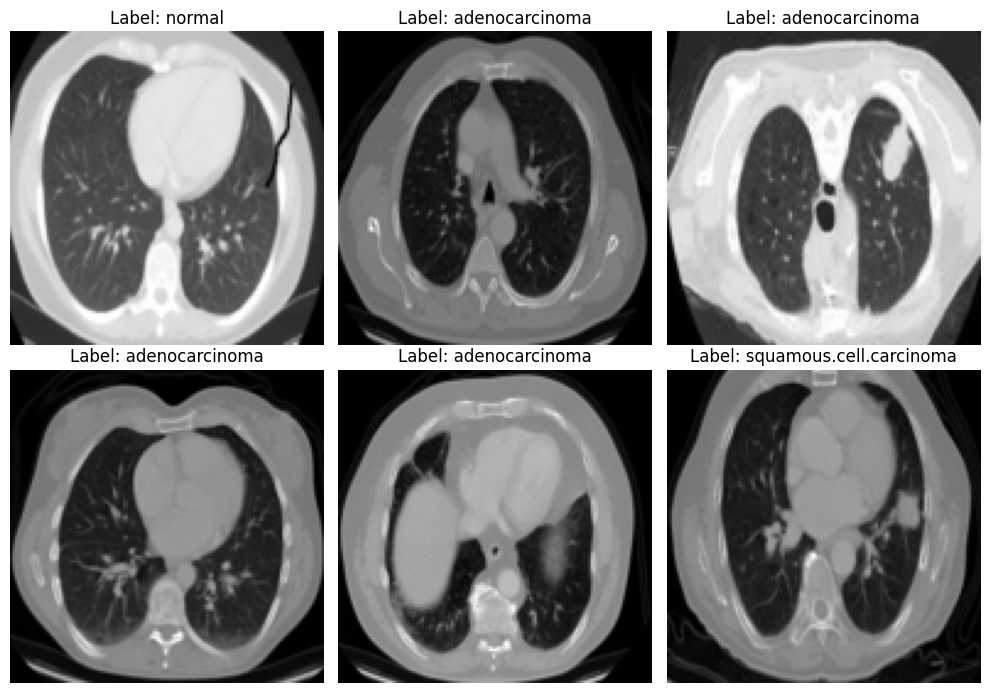

In [254]:
# Take a look at some train data
dataset_name = 'train'
data_loader = dataloaders[dataset_name]

# Randomly select a batch from the data loader
images, labels = next(iter(data_loader))

# Print out the shape
print(images[0].shape)

# Define class labels
class_labels = image_datasets[dataset_name].classes

# Display the images
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for i, ax in enumerate(axes.flatten()):
    image = images[i].permute(1, 2, 0)  # Change the tensor shape from (C, H, W) to (H, W, C)
    label = labels[i].item()
    class_name = class_labels[label]  # Get the class label name

    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {class_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Hyper-parameters
num_epochs = 25
learning_rate = 0.001
num_classes = len(class_labels)

In [267]:
# Create model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)

        self.fc1 = nn.Linear(in_features=64*16, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.size(0), -1) # Flatten

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [268]:
# Create model and loss functions
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [269]:
# Function to train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print training progress
            if (i+1) % 20 == 0:
                elapsed_time = time.time() - start_time
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}, Elapsed Time: {elapsed_time:.2f} sec')
                start_time = time.time()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

In [270]:
# Merge train and test datasets
train_dataset = image_datasets['train']
test_dataset = image_datasets['test']

merged_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# Create a new combined DataLoader
merged_dataloader = torch.utils.data.DataLoader(merged_dataset, batch_size=6, shuffle=True, num_workers=0)

In [271]:
# Train the model
train_model(model, criterion, optimizer, merged_dataloader, num_epochs)

Epoch [1/25], Step [20/155], Loss: 1.3219, Elapsed Time: 0.85 sec
Epoch [1/25], Step [40/155], Loss: 1.2678, Elapsed Time: 1.00 sec
Epoch [1/25], Step [60/155], Loss: 1.3848, Elapsed Time: 0.79 sec
Epoch [1/25], Step [80/155], Loss: 0.9934, Elapsed Time: 0.93 sec
Epoch [1/25], Step [100/155], Loss: 0.9536, Elapsed Time: 0.92 sec
Epoch [1/25], Step [120/155], Loss: 1.6607, Elapsed Time: 0.97 sec
Epoch [1/25], Step [140/155], Loss: 1.2347, Elapsed Time: 0.90 sec
Epoch [1/25], Loss: 1.1569
Epoch [2/25], Step [20/155], Loss: 1.0444, Elapsed Time: 0.84 sec
Epoch [2/25], Step [40/155], Loss: 1.3445, Elapsed Time: 0.83 sec
Epoch [2/25], Step [60/155], Loss: 1.1816, Elapsed Time: 0.83 sec
Epoch [2/25], Step [80/155], Loss: 0.4635, Elapsed Time: 0.86 sec
Epoch [2/25], Step [100/155], Loss: 1.0514, Elapsed Time: 0.80 sec
Epoch [2/25], Step [120/155], Loss: 1.0850, Elapsed Time: 0.85 sec
Epoch [2/25], Step [140/155], Loss: 1.3479, Elapsed Time: 0.89 sec
Epoch [2/25], Loss: 1.0083
Epoch [3/25], St

In [273]:
# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = correct / total

    # Calculate F1 score, precision, and recall for each class
    f1_scores = f1_score(y_true, y_pred, average=None)
    precision_scores = precision_score(y_true, y_pred, average=None)
    recall_scores = recall_score(y_true, y_pred, average=None)

    return accuracy, f1_scores, precision_scores, recall_scores

# Evaluate the model on the validation set
val_loader = dataloaders['valid']
accuracy, f1_scores, precision_scores, recall_scores = evaluate_model(model, val_loader)

print(f"Overall Model Accuracy: {accuracy}\n")
# Print the results
for i in range(num_classes):
    class_label = class_labels[i]
    print(f"Class: {class_label}")
    print(f"F1 score: {f1_scores[i]}")
    print(f"Precision: {precision_scores[i]}")
    print(f"Recall: {recall_scores[i]}")
    print()


Overall Model Accuracy: 0.9027777777777778

Class: adenocarcinoma
F1 score: 0.8800000000000001
Precision: 0.8148148148148148
Recall: 0.9565217391304348

Class: large.cell.carcinoma
F1 score: 0.9
Precision: 0.9473684210526315
Recall: 0.8571428571428571

Class: normal
F1 score: 0.9166666666666666
Precision: 1.0
Recall: 0.8461538461538461

Class: squamous.cell.carcinoma
F1 score: 0.9333333333333333
Precision: 0.9333333333333333
Recall: 0.9333333333333333



In [274]:
# Save model
FILE = 'ct-scan-model.pth'
torch.save(model.state_dict(), FILE)

In [265]:
# Manuel test
# Load and preprocess the test image
test_image = Image.open('./testdata.jpg').convert('L')
test_image = composed_transform(test_image)
test_image = test_image.unsqueeze(0).to(device)

# Pass the test image through the model for prediction
model.eval()
with torch.no_grad():
    output = model(test_image)
    _, predicted_class = torch.max(output, 1)

# Get the predicted class label
predicted_label = class_labels[predicted_class.item()]
print("Predicted Label:", predicted_label)


Predicted Label: large.cell.carcinoma
